1. Netflix Prize competition (ensemble learning)
2. Three methods
    1. bagging
    2. boosting
    3. stacking



In [ ]:
# toss a coin with 0.51 probability heads

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score



### Why ensemble can do better
Suppose you build an ensemble containing 1,000 classifiers that are individ‐ ually correct only 51% of the time (barely better than random guessing). If you pre‐ dict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they
are trained on the same data. They are likely to make the same
types of errors, so there will be many majority votes for
the wrong class, reducing the ensemble’s accuracy.



In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.2, random_state=42)
print([a.shape for a in [X_train, X_test, y_train, y_test]])

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float))
X_test = scaler.fit_transform(X_test.astype(np.float))

In [ ]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
            estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
            voting='hard')

voting_clf.fit(X_train, y_train)

In [ ]:

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

If all classifiers are able to estimate class probabilities (i.e., they have a
pre dict_proba() method), then you can tell Scikit-Learn to predict the class
with the highest class probability, averaged over all the individual classifiers.
This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities.
1. If ‘hard’, uses predicted class labels for majority rule voting.
2. if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.


### Bagging and pasting
One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed.
Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.
1. When sampling is performed with replacement, this method is called bagging1 (short for bootstrap aggregating2).
2. When sampling is performed without replacement, it is called pasting.3

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.4 Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

#### How to plot decision boundary?
#### what is out of bag probability: 63 vs 37?


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    max_samples=1000, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)


With bagging, some instances may be sampled several times for any
given predictor, while others may not be sampled at all.
By default a BaggingClassifier samples m training instances with
replacement (bootstrap=True), where m is the size of the training
set. This means that only about 63% of the training instances are
sampled on average for each predictor. The remaining 37% of
the training instances that are not sampled are called out-of-bag
(oob) instances. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it
can be evaluated on these instances, without the need for a
separate validation set. You can evaluate the ensemble itself
by averaging out the oob evaluations of each predictor.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    bootstrap=True, n_jobs=4, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

### Random Patches and Random Subspaces
Sampling subfeatures instead of subset of training data.

1. Sampling both training instances and features is called the Random Patches method.
2. Keeping all training instances (i.e., bootstrap=False and max_sam ples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_fea tures smaller than 1.0) is called the Random Subspaces method.


### Random forest

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperpara‐ meters of a BaggingClassifier to control the ensemble itself.11

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node (see Chapter 6), it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:

In [19]:
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 n_jobs=-1,
                                 max_samples=0.3,
                                 max_features=0.5)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

In [20]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.6505714285714286


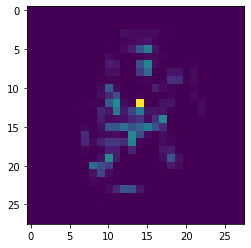

In [21]:
importance = rnd_clf.feature_importances_
importance = importance.reshape((28, 28))
plt.imshow(importance)

In [ ]:
#这个和random forest效果差不多

bag_clf = BaggingClassifier(
     DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
     n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)


### Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10483241230767104
sepal width (cm) 0.02338246283660498
petal length (cm) 0.4217346734134684
petal width (cm) 0.45005045144225575


### Extra-Trees

Later

## Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method
that can combine several weak learners into a strong learner. The general idea
of most boosting methods is to train predictors sequentially, each trying to
correct its predecessor.

### AdaBoost (Adaptive Boosting)

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predic‐ tors focusing more and more on the hard cases.
This is the technique used by Ada‐Boost. Once all predictors are trained, the ensemble makes predictions very much like bag‐ ging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

At the beginning, each instance (not predictor) weight $w_i$ is initially set to $\frac{1}{m}$.
A first predictor is trained and its weighted error rate $r_1$ is computed on
the training set, see Equation

$$r_j = \frac{\sum_{\hat{y}_{j}^{(i)} \neq y^{(i)}} w^{(i)}}{\sum_i w^{(i)}}$$

where $\hat{y}_{j}^{(i)}$ is the j-th predictor’s prediction for the i-th instance.

例如，如果第1个分类器有5个错，那$r_j=\frac{5}{m}$.

The predictor’s weight $\alpha_j$ is then computed using Equation 7-2, where $\eta$ is the
learning rate hyperparameter (defaults to 1). The more accurate the predictor
is, the higher its weight will be. If it is just guessing randomly, then its
weight will be close to zero. However, if it is most often wrong (i.e., less
accurate than random guessing), then its weight will be negative.

$$\alpha_{j}=\eta \log \frac{1-r_{j}}{r_{j}}$$

Next the instance weights are updated using Equation 7-3: the misclassified instances are boosted.

\begin{equation}
w^{(i)} \leftarrow\left\{\begin{array}{ll}
w^{(i)} & \text { if } \widehat{y}_{j}^{(i)}=y^{(i)} \\
w^{(i)} \exp \left(\alpha_{j}\right) & \text { if } \widehat{y}_{j}^{(i)} \neq y^{(i)}
\end{array}\right.
\end{equation}

如果这个分类分错了，在权重越大的分类器上分错了，增加的权重越多。那么Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^{m} w^{(i)}$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes

\begin{equation}
\hat{y}(\mathbf{x})=
\underset{k}{\operatorname{argmax}} \sum_{j=1 \atop \hat{y}_j(\mathbf{x})=k}^{N}  p_{jk}\alpha_{j}
\end{equation},   where $N$ is the number of predictors.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1), n_estimators=200,
 algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)


### Gradient Boosting.

Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [23]:
import pandas as pd
from sklearn.impute import SimpleImputer

In [24]:
housing = pd.read_csv("datasets/housing/housing.csv")
print(housing.shape)
housing.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [25]:
y = housing['median_house_value'].to_numpy()
X = housing.drop(['ocean_proximity', 'median_house_value'], axis=1)

In [26]:
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)
X = scaler.fit_transform(X)
print(X.shape, y.shape)


(20640, 8) (20640,)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [29]:
# the second regressor on the residual error made by the first one

y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y2)


DecisionTreeRegressor(max_depth=2)

In [30]:
# Then we train a third regressor on the residual errors made
# by the second predictor:

y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y3)

DecisionTreeRegressor(max_depth=2)

In [31]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[130860.53774343 130860.53774343 318596.14241791 ... 421288.09578806
 130860.53774343 239261.54987149]


In [32]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

77807.19671402498

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=30, learning_rate=0.5)
gbrt.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, gbrt.predict(X_test)))


59593.7802452775

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you
will need more trees in the ensemble to fit the train‐ ing set, but the predictions will usually
generalize better. This is a regularization tech‐ nique called shrinkage.
Figure 7-10 shows two GBRT ensembles trained with a low learning rate:
the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.


In [54]:
# Early stopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


In [78]:
gbrt = GradientBoostingRegressor(max_depth=8, n_estimators=200)
gbrt.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=8, n_estimators=200)

162


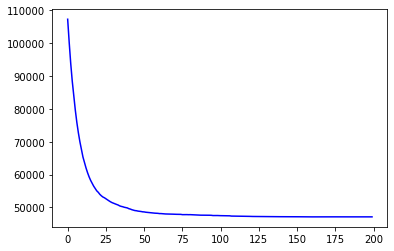

In [79]:
errors = [np.sqrt(mean_squared_error(y_val, y_pred)) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)#%%

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)
print(bst_n_estimators)
plt.plot(range(len(errors)), errors, 'b-')



In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
gbrt.n_estimators = n_estimators
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) if val_error < min_val_error:
            min_val_error = val_error
error_going_up = 0 else:
error_going_up += 1
if error_going_up == 5:
break # early stopping

The GradientBoostingRegressor class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training
each tree. For example, if subsample=0.25, then each tree is trained on 25%
of the training instan‐ ces, selected randomly. As you can probably guess
by now, this trades a higher bias for a lower variance. It also speeds
up training considerably. This technique is called Stochastic Gradient
Boosting.


It is worth noting that an optimized implementation of Gradient Boosting
is available in the popular python library XGBoost, which stands for Extreme
Gradient Boosting. This package was initially developed by Tianqi Chen as
part of the Distributed (Deep) Machine Learning Community (DMLC), and it
aims at being extremely fast, scalable and portable. In fact, XGBoost
is often an important component of the winning entries in ML competitions.
XGBoost’s API is quite similar to Scikit-Learn’s:

In [83]:
! conda install -c -y conda-forge xgboost

usage: conda install [-h] [--revision REVISION] [-n ENVIRONMENT | -p PATH]
                     [-c CHANNEL] [--use-local] [--override-channels]
                     [--repodata-fn REPODATA_FNS] [--strict-channel-priority]
                     [--no-channel-priority] [--no-deps | --only-deps]
                     [--no-pin] [--copy] [-C] [-k] [--offline] [-d] [--json]
                     [-q] [-v] [-y] [--download-only] [--show-channel-urls]
                     [--file FILE] [--force-reinstall]
                     [--freeze-installed | --update-deps | -S | --update-all | --update-specs]
                     [-m] [--clobber] [--dev]
                     [package_spec [package_spec ...]]
conda install: error: argument -c/--channel: expected one argument


In [84]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [85]:
# XGBoost also offers several nice features, such as automatically taking care of early stopping:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)


[0]	validation_0-rmse:173049.51562
[1]	validation_0-rmse:130653.92188
[2]	validation_0-rmse:102304.36719
[3]	validation_0-rmse:84829.88281
[4]	validation_0-rmse:73296.75000
[5]	validation_0-rmse:66490.70312
[6]	validation_0-rmse:62210.29688
[7]	validation_0-rmse:59900.10547
[8]	validation_0-rmse:57965.00391
[9]	validation_0-rmse:56495.08594
[10]	validation_0-rmse:55466.91406
[11]	validation_0-rmse:53366.54297
[12]	validation_0-rmse:52798.69141
[13]	validation_0-rmse:52339.94922
[14]	validation_0-rmse:51990.00391
[15]	validation_0-rmse:51933.79688
[16]	validation_0-rmse:51338.07812
[17]	validation_0-rmse:51068.67188
[18]	validation_0-rmse:51001.62891
[19]	validation_0-rmse:50734.23828
[20]	validation_0-rmse:50434.51172
[21]	validation_0-rmse:50376.27344
[22]	validation_0-rmse:50210.96484
[23]	validation_0-rmse:50111.66406
[24]	validation_0-rmse:49815.51172
[25]	validation_0-rmse:49629.18750
[26]	validation_0-rmse:49634.97266
[27]	validation_0-rmse:49637.30859


### Stacking
The last Ensemble method we will discuss in this chapter is called stacking
(short for stacked generalization).18 It is based on a simple idea: instead
of using trivial functions (such as hard voting) to aggregate the predictions
of all predictors in an ensemble, why don’t we train a model to perform this
aggregation? Figure 7-12 shows such an ensemble performing a regression
task on a new instance. Each of the bottom three predictors predicts a
different value (3.1, 2.7, and 2.9), and then the final predictor (called
a blender, or a meta learner) takes these predictions as inputs and
makes the final prediction (3.0).